# ANIME DATA ANALYSIS

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

warnings.filterwarnings("ignore")
%matplotlib inline

2025-04-28 09:56:57.179851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 09:56:57.201037: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 09:56:57.356562: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 09:56:57.498034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745814417.604070    4970 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745814417.63

# Working on animelist.csv

In [2]:
animelist = pd.read_csv('../artifacts/raw/animelist.csv', low_memory=True, usecols = ["user_id","anime_id", "rating"])

In [3]:
animelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 137.3 MB


In [4]:
animelist.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [5]:
len(animelist)

6000000

# Data Processing

Finding all the Experienced users who have rated more than 50 animes

In [6]:
n_ratings = animelist["user_id"].value_counts()
n_ratings

user_id
11100    14429
16869     8943
10255     8403
4773      5735
6852      5406
         ...  
2899         1
13430        1
5404         1
26           1
19667        1
Name: count, Length: 18112, dtype: int64

In [7]:

ratings_df = animelist[animelist["user_id"].isin(n_ratings[n_ratings >= 50].index)]
print(len(ratings_df))

5944292


In [8]:
min_rating = min(ratings_df["rating"])
min_rating

0

In [9]:
max_rating = max(ratings_df["rating"])
max_rating

10

In [10]:
avg_rating = np.mean(ratings_df["rating"])
avg_rating

np.float64(4.278059859778086)

Min-Max Scaling the "rating" variable

In [11]:
ratings_df["rating"] = ratings_df["rating"].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)


In [12]:
ratings_df.duplicated().sum()

np.int64(0)

In [13]:
ratings_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [14]:
user_ids = ratings_df["user_id"].unique().tolist()
len(user_ids)

15456

Creating encoders and Decoders for Users and Animes

In [15]:
user2user_encoded = {x:i for i , x in enumerate(user_ids)}
user2user_decoded = {i:x for i , x in enumerate(user_ids)}

In [16]:
print(len(user2user_encoded), len(user2user_decoded))
print(list(user2user_encoded.items())[:5])
print(list(user2user_decoded.items())[:5])

15456 15456
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


In [17]:
ratings_df["user"] = ratings_df["user_id"].map(user2user_encoded)
ratings_df.head()

,user_id,anime_id,rating,user
0,0,67,0.9,0
1,0,6702,0.7,0
2,0,242,1.0,0
3,0,4898,0.0,0
4,0,21,1.0,0


In [18]:
anime_ids = ratings_df["anime_id"].unique().tolist()
anime2anime_encoded = {x:i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i , x in enumerate(anime_ids)}
ratings_df["anime"] = ratings_df["anime_id"].map(anime2anime_encoded)
ratings_df.head()

,user_id,anime_id,rating,user,anime
0,0,67,0.9,0,0
1,0,6702,0.7,0,1
2,0,242,1.0,0,2
3,0,4898,0.0,0,3
4,0,21,1.0,0,4


In [19]:
print(len(anime2anime_encoded), len(anime2anime_decoded))
print(list(anime2anime_encoded.items())[:5])
print(list(anime2anime_decoded.items())[:5])

17225 17225
[(67, 0), (6702, 1), (242, 2), (4898, 3), (21, 4)]
[(0, 67), (1, 6702), (2, 242), (3, 4898), (4, 21)]


Shuffling the data

In [20]:
ratings_df = ratings_df.sample(frac = 1, random_state=43).reset_index(drop=True)
ratings_df.head()

,user_id,anime_id,rating,user,anime
0,15597,372,0.0,12217,921
1,965,17247,0.9,773,1639
2,3768,444,0.8,2952,1462
3,4441,1222,0.9,3455,915
4,10998,42205,0.0,8573,200


In [21]:
X = ratings_df[["user", "anime"]].values
y = ratings_df["rating"]

In [22]:
test_size = 1000
train_indices = ratings_df.shape[0] - test_size


We will test on only 1000 rows of the data

In [23]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5943292, 2)
X_test shape: (1000, 2)
y_train shape: (5943292,)
y_test shape: (1000,)


In [25]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

We will separate the Users and Animes as two separate arrays within a list

In [26]:
X_train_array = [ X_train[:,0], X_train[:,1]]
X_test_array = [ X_test[:,0], X_test[:,1]]

# Model Architecture

In [27]:
def RecommenderNet():
    embedding_size = 128
    
    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=len(user2user_encoded), output_dim=embedding_size)(user)
    
    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=len(anime2anime_encoded), output_dim=embedding_size)(anime)
    
    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", optimizer='Adam', metrics=["mae","mse"])
    return model

In [28]:
model = RecommenderNet()
model.summary()

2025-04-28 09:57:03.728279: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,978,368 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,204,800 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,183,174 (15.96 MB)

 Trainable params: 4,183,172 (15.96 MB)

 Non-trainable params: 2 (8.00 B)

In [29]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return(max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs)+min_lr

In [30]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose = 0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [31]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [32]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - loss: 0.7981 - mae: 0.3845 - mse: 0.1985 - val_loss: 0.7757 - val_mae: 0.3806 - val_mse: 0.1937 - learning_rate: 1.0000e-05
Epoch 2/20
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - loss: 0.7935 - mae: 0.3829 - mse: 0.1967 - val_loss: 0.7876 - val_mae: 0.3826 - val_mse: 0.1976 - learning_rate: 1.8000e-05
Epoch 3/20
595/595 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - loss: 0.7853 - mae: 0.3801 - mse: 0.1936 - val_loss: 0.7837 - val_mae: 0.3821 - val_mse: 0.1963 - learning_rate: 2.6000e-05
Epoch 4/20
595/595 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - loss: 0.7733 - mae: 0.3756 - mse: 0.1887 - val_loss: 0.7767 - val_mae: 0.3806 - val_mse: 0.1938 - learning_rate: 3.4000e-05


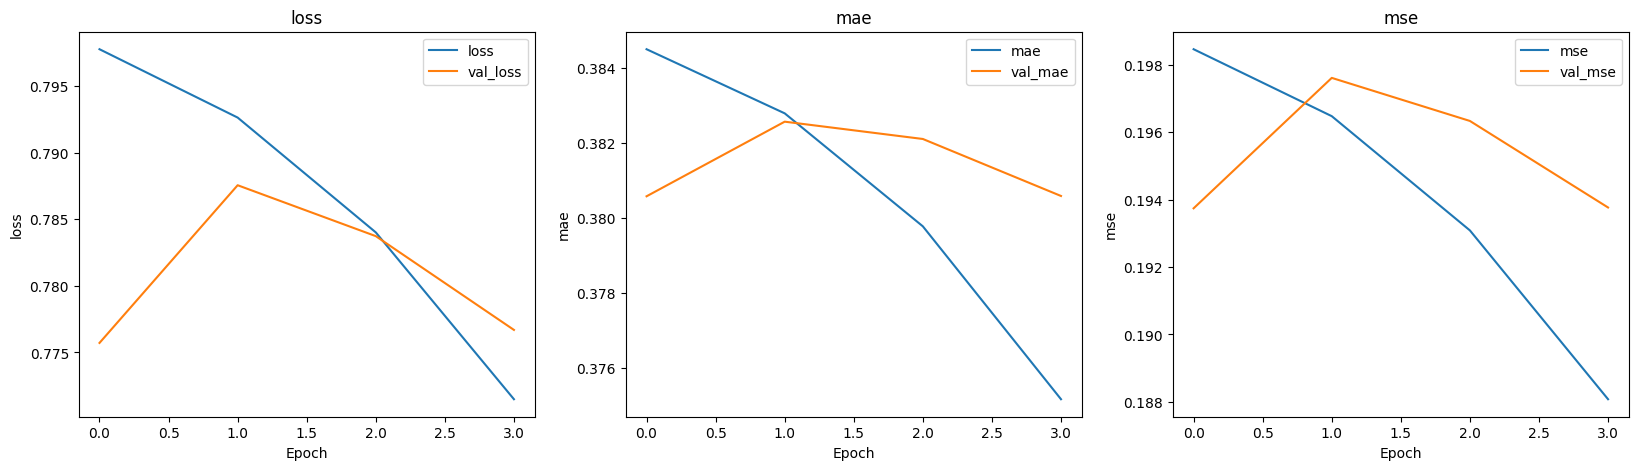

In [33]:
metrics = ["loss", "mae", "mse"]
def plot_history(history, metrics):
    plt.figure(figsize=(20, 5))
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.plot(history.history["val_" + metric], label="val_" + metric)
        plt.title(metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
    plt.show()
plot_history(history, metrics)    

In [34]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [35]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

# Working on anime.csv

In [36]:
anime = pd.read_csv("../artifacts/raw/anime.csv")
anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [37]:
anime = anime.replace("Unknown", np.nan)

In [38]:
def get_anime_name(df, anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print(f"Anime id {anime_id} not found")
    return name

In [39]:
anime["anime_id"] = anime["MAL_ID"]
anime["eng_version"] = anime["English name"]
anime["eng_version"] = anime.anime_id.apply(lambda x: get_anime_name(anime, x))
anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [40]:
anime67 = get_anime_name(anime, 6702)
anime67

'Fairy Tail'

In [41]:
anime.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [42]:
anime.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [77]:
anime = anime[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [80]:
anime.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [45]:
def getAnimeFrame(user_input, df):
    if isinstance(user_input, int):
        return df[df["anime_id"] == user_input]
    elif isinstance(user_input, str):
        return df[df["eng_version"] == user_input]

In [46]:
getAnimeFrame(9253, anime)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


In [47]:
getAnimeFrame("Steins;Gate", anime)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


# Working on anime_with_synopsis.csv

In [48]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]
synopsis_df = pd.read_csv("../artifacts/raw/anime_with_synopsis.csv", usecols=cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [49]:
synopsis_df[synopsis_df["Name"] == "Steins;Gate"]

,MAL_ID,Name,Genres,sypnopsis
4953,9253,Steins;Gate,"Thriller, Sci-Fi",The self-proclaimed mad scientist Rintarou Oka...


In [50]:
def getSynopsis(user_input, df):
    if isinstance(user_input, int):
        return df[df["MAL_ID"] == user_input].sypnopsis.values[0]
    elif isinstance(user_input, str):
        return df[df["Name"] == user_input].sypnopsis.values[0]

In [51]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# Building Content Based Recommendation

In [52]:
pd.set_option("max_colwidth", None)

In [53]:
def find_similar_anime(name, anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, synopsis_df, n=5, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, anime_df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n+1
        
        if neg:
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        print(f"Anime Closest to {name}")
    
        if return_dist:
            return dists,closest
        
        SimilarityArray = []

        for close in closest:
            try:
                decoded_id = anime2anime_decoded.get(close)
                
                synopsis = getSynopsis(decoded_id, synopsis_df)
                
                anime_frame = getAnimeFrame(decoded_id, anime_df)
                anime_name = anime_frame["eng_version"].values[0]
                genre = anime_frame["Genres"].values[0]
                
                similarity = dists[close]
                
                SimilarityArray.append({"name": anime_name,
                                        "anime_id": decoded_id,
                                        "similarity": similarity,
                                        "genre": genre,
                                        "synopsis": synopsis
                                        })
            except Exception as e:
                # print(f"Error: {e}")
                continue    
        Frame = pd.DataFrame(SimilarityArray).sort_values(by=["similarity"], ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print(f"Error: {e}")

 

In [54]:
find_similar_anime("Steins;Gate", anime_weights, anime2anime_encoded, anime2anime_decoded, anime, synopsis_df)

Anime Closest to Steins;Gate


,name,similarity,genre,synopsis
3,Top Secret: The Revelation,0.323853,"Sci-Fi, Mystery, Police, Psychological, Shoujo",ly developed method allows to display the memories of dead people. It is used to solve difficult murder cases. But at what cost? What of the dead's privacy as strangers poke about in their most private memories? What about the effects the imageries may have on the persons whose jobs require going through psychotic murderers' minds and experience whatever emotions and feelings these murderers felt as they skin and disembowel their victims? (Source: Adapted from manga description)
2,THE IDOLM@STER CINDERELLA GIRLS Theater,0.315163,"Slice of Life, Comedy",Unaired episodes of Cinderella Girls Gekijou included in the DVD and Blu-ray release.
1,Kowasugimasu.,0.301978,"Comedy, Horror, Music",zarre short animation by Takashi Taniguchi.
0,Sakugasaku,0.291561,Music,"usic video for Uchikubi Gokumon Doukoukai's song ""Sakugasaku."""


# User Based Recommendation

In [55]:
def find_similar_user(input_item, user_weights, user2user_encoded, user2user_decoded, n=5, return_dist=False, neg = False):
    try:
        index = input_item
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n+1
        if neg:
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        print(f"Users Closest to {input_item}")
    
        if return_dist:
            return dists,closest
        
        SimilarityArray = []

        for close in closest:
            try:
                similarity = dists[close]
                
                if isinstance(input_item, int):
                    decoded_id = user2user_decoded.get(close)
                    SimilarityArray.append({
                        "similar_users": decoded_id,
                        "similarity": similarity
                    })

            except Exception as e:
                print(f"Error: {e}")
                continue    
        similar_users = pd.DataFrame(SimilarityArray).sort_values(by=["similarity"], ascending=False)
        similar_users = similar_users[similar_users["similar_users"] !=index]
        return similar_users
    
    except Exception as e:
        print(f"Error: {e}")

In [56]:
find_similar_user(int(11880), user_weights, user2user_encoded, user2user_decoded, n=5)

Users Closest to 11880


,similar_users,similarity
4,14454,0.354137
3,14256,0.336670
2,1636,0.319987
1,11132,0.309104
0,438,0.308171


In [57]:
def showWordCloud(all_genres):
    genre_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(15, 8))
    plt.imshow(genre_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [58]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    if plot:
        showWordCloud(all_genres)
    return genres_list

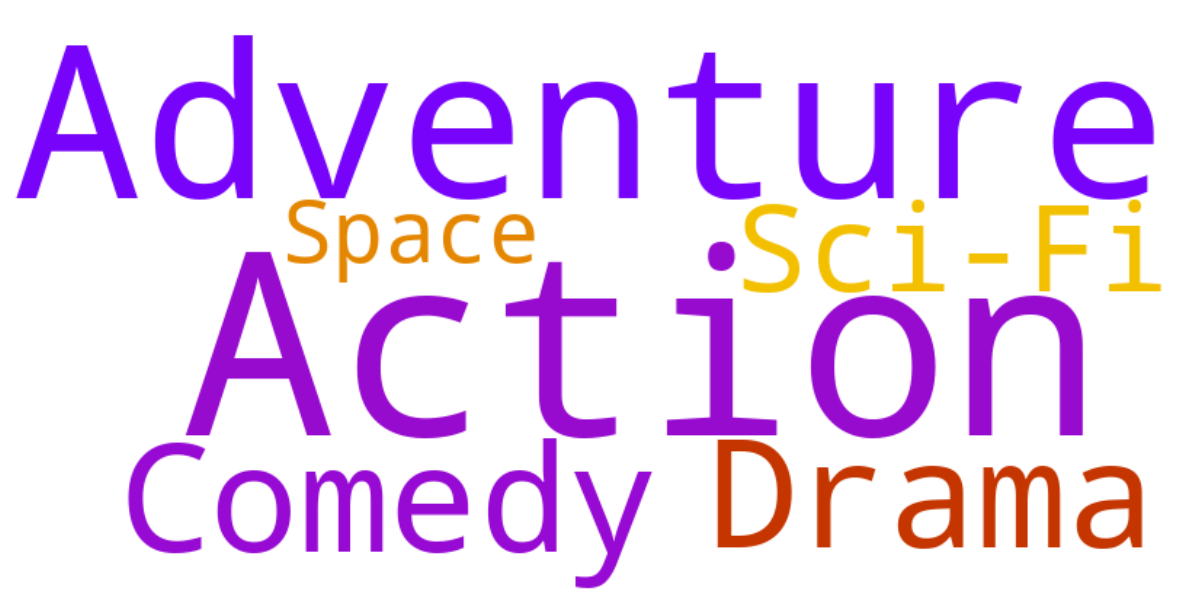

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [59]:
x = getAnimeFrame(1,anime)
getFavGenre(x, plot=True)

In [60]:
ratings_df.head()

,user_id,anime_id,rating,user,anime
0,15597,372,0.0,12217,921
1,965,17247,0.9,773,1639
2,3768,444,0.8,2952,1462
3,4441,1222,0.9,3455,915
4,10998,42205,0.0,8573,200


In [ ]:
def get_user_preferences(user_id, ratings_df, anime_df, verbose=0, plot=False):

    animes_watched_by_user = ratings_df[ratings_df["user_id"] == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user["rating"], 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user["rating"] >= user_rating_percentile]
    top_animes = (animes_watched_by_user.sort_values(by=["rating"], ascending=False).anime_id.values)
    anime_df_rows = anime_df[anime_df["anime_id"].isin(top_animes)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if verbose!=0:
        print(f"User {user_id} has watched {len(animes_watched_by_user)} animes")
        print(f"User {user_id} has rated {len(animes_watched_by_user[animes_watched_by_user['rating'] >= user_rating_percentile])} animes with rating >= {user_rating_percentile}")
        print(f"Top 5 animes watched by user {user_id}:")
        print(anime_df_rows.head(5))
    
    if plot:
        getFavGenre(anime_df_rows, plot=True)
    return anime_df_rows

User 11880 has watched 190 animes
User 11880 has rated 190 animes with rating >= 0.8
Top 5 animes watched by user 11880:
                          eng_version  \
3971  Fullmetal Alchemist:Brotherhood   
9913                 Gintama Season 4   
6474                  Hunter x Hunter   
6006                 Gintama Season 2   
741     Legend of the Galactic Heroes   

                                                                   Genres  
3971  Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen  
9913         Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen  
6474                     Action, Adventure, Fantasy, Shounen, Super Power  
6006         Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen  
741                                        Military, Sci-Fi, Space, Drama  


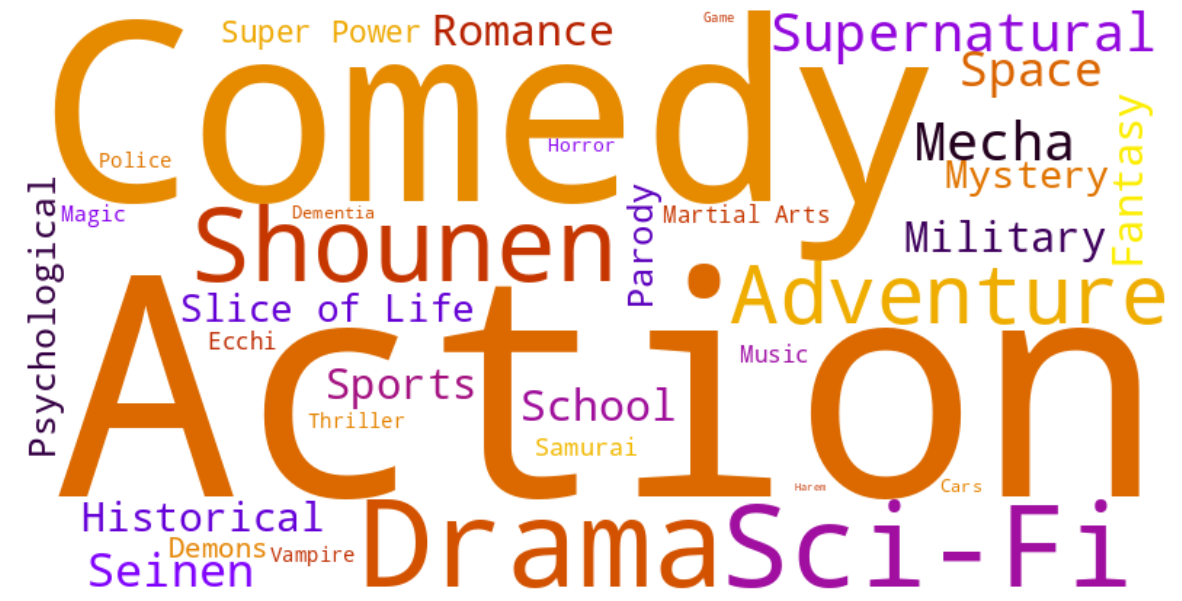

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [76]:
get_user_preferences(11880, ratings_df, anime, verbose=1, plot=True)

In [66]:
def get_user_based_recommendations(similar_users, user_preferences, anime_df, ratings_df, synopsis_df, n=5):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users["similar_users"].values:
        preference_list = get_user_preferences(int(user_id), ratings_df, anime_df, plot=False)
        preference_list = preference_list[~preference_list["eng_version"].isin(user_preferences["eng_version"].values)]

        if not preference_list.empty:
            anime_list.append(preference_list["eng_version"].values)
        
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
        
        for i, anime_name in enumerate(sorted_list.index):
            number_of_user_preferences = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                try:
                    frame = getAnimeFrame(anime_name, anime_df)
                    anime_id = frame["anime_id"].values[0]
                    genre = frame["Genres"].values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)
                    recommended_animes.append({
                        "anime_id": anime_id,
                        "name": anime_name,
                        "number_of_user_preferences": number_of_user_preferences,
                        "genre": genre,
                        "synopsis": synopsis
                    })
                except Exception as e:
                    print(f"Error: {e}")
                    continue
                
    return pd.DataFrame(recommended_animes).head(n)

In [73]:
similar_users = find_similar_user(int(11880), user_weights, user2user_encoded, user2user_decoded, n=20)
user_preferences = get_user_preferences(11880, ratings_df, anime, verbose=0, plot=False)

get_user_based_recommendations(similar_users, user_preferences, anime, ratings_df, synopsis_df, n=5)

Users Closest to 11880


,anime_id,name,number_of_user_preferences,genre,synopsis
0,16498,Attack on Titan,13,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,1535,Death Note,12,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2,23273,Your Lie in April,11,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. Two years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. Based on the manga series of the same name, Shigatsu wa Kimi no Uso approaches the story of Kousei's recovery as he discovers that music is more than playing each note perfectly, and a single melody can bring in the fresh spring air of April."
3,33489,Little Witch Academia,11,"Adventure, Comedy, Fantasy, Magic, School","""A believing heart is your magic!""—these were the words that Atsuko ""Akko"" Kagari's idol, the renowned witch Shiny Chariot, said to her during a magic performance years ago. Since then, Akko has lived by these words and aspired to be a witch just like Shiny Chariot, one that can make people smile. Hence, even her non-magical background does not stop her from enrolling in Luna Nova Magical Academy. However, when an excited Akko finally sets off to her new school, the 

# Hybrid Recommender System

In [105]:
def hybrid_recommendation(user_id, ratings_df, anime_df, user_weight=0.5, content_weight=0.5):
    
    # Get user-based recommendations
    similar_users = find_similar_user(user_id, user_weights, user2user_encoded, user2user_decoded, n=20)
    user_preferences = get_user_preferences(user_id, ratings_df, anime_df)
    user_recommended_anime = get_user_based_recommendations(similar_users, user_preferences, anime_df, ratings_df, synopsis_df, n=5)
    user_recommended_anime_list = user_recommended_anime["name"].tolist()
    
    # Get content-based recommendations
    content_recommended_anime = []
    for anime in user_recommended_anime_list:
        try:
            similar_animes = find_similar_anime(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, synopsis_df, n=5)
            if similar_animes is not None and not similar_animes.empty:
                content_recommended_anime.extend(similar_animes["name"].to_list())
            else:
                print(f"No similar animes found to {anime}")
        except Exception as e:
            print(f"Error: {e}")
            continue
        
    combined_scores = {}
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_anime:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:5]]


In [109]:
hybrid_recommended = hybrid_recommendation(1000,ratings_df,anime)

Users Closest to 1000
Anime Closest to Spirited Away
Anime Closest to Princess Mononoke
Anime Closest to The Disappearance of Haruhi Suzumiya
Anime Closest to The Girl Who Leapt Through Time
Anime Closest to Hunter x Hunter


In [110]:
hybrid_recommended

['Spirited Away',
 'Princess Mononoke',
 'The Disappearance of Haruhi Suzumiya',
 'The Girl Who Leapt Through Time',
 'Hunter x Hunter']